In [ ]:
!pip install transformers
!pip install pandas
!pip install sklearn

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from transformers import BertTokenizerFast, TFBertForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from google.colab import drive

RANDOM_SEED = 7777
PRETRAINED_MODEL_NAME = "monologg/koelectra-base-v3-discriminator"
%matplotlib inline
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/HKT/Dataset/train_data.csv")
tokenizer = BertTokenizerFast.from_pretrained(PRETRAINED_MODEL_NAME)
x_data = []
Y_data = []
max_len = 30
# train데이터를 받아옴
for _, (_, title, topic_idx) in train_data.iterrows():
    x_data.append(title)
    Y_data.append(topic_idx)
# train, eval 분리 | 허용되는 입력이 list, ndarray, pd.DataFrame, scipy-sparse matrices 뿐이라 먼저 진행됨.
x_train, x_val, Y_train, Y_val = train_test_split(x_data, Y_data, train_size = 0.8, shuffle=True, random_state=RANDOM_SEED)

# train 토큰화 + 정수인코딩 + 패딩
x_train = tokenizer.batch_encode_plus(x_train, padding=True, truncation=True)
# train 텐서화
encoded_x_train = dict()
for key, values in x_train.items():
    encoded_x_train[key] = tf.convert_to_tensor(values)

# val 토큰화 + 정수인코딩 + 패딩
x_val = tokenizer.batch_encode_plus(x_val, padding=True, truncation=True)
# val 텐서화
encoded_x_val = dict()
for key, values in x_val.items():
    encoded_x_val[key] = tf.convert_to_tensor(values)

# label 원핫인코딩 + 텐서화
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)

# 데이터셋 제작
train_dataset = tf.data.Dataset.from_tensor_slices((encoded_x_train, Y_train)).shuffle(1000).batch(16)
val_dataset = tf.data.Dataset.from_tensor_slices((encoded_x_val, Y_val)).shuffle(1000).batch(16)

In [ ]:
tf.random.set_seed(RANDOM_SEED)

# 모델 선언
model = TFBertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels=7)

# batch_size=16/32, lr(Adam)=5/3/2e-5, epoch=3/4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics="accuracy",
)

hist = model.fit(
    train_dataset,
    epochs = 4,
    batch_size = 32,
    validation_data = val_dataset,
    callbacks = [EarlyStopping(monitor="val_loss", patience=2),
                 ModelCheckpoint("./Model/best_model", monitor="val_accuracy", mode="max", save_best_only=True)]
)

model.save("./Model/TC_model")

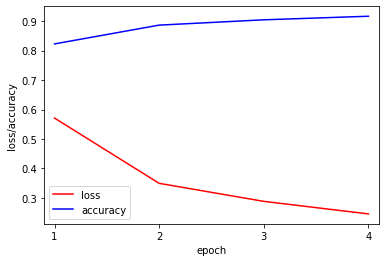

In [ ]:
# loss, accuracy 그래프
plt.plot(range(1, 5), hist.history["loss"], "r", label="loss")
plt.plot(range(1, 5), hist.history["accuracy"], "b", label="accuracy")
plt.xlabel("epoch")
plt.ylabel("loss/accuracy")
plt.xticks([1,2,3,4])
plt.xlim(0.9,4.1)
plt.legend()
plt.show()

In [ ]:
# make submission
# model = tf.keras.models.load_model("./Model/best_model")  # 모델 로드
test_data = pd.read_csv("/content/drive/MyDrive/HKT/Dataset/test_data.csv")
tokenizer = BertTokenizerFast.from_pretrained("monologg/koelectra-base-v3-discriminator")  # PRETRAINED_MODEL_NAME

# test데이터를 받아옴
index_list = []
test_x = []
for data in test_data.iterrows():
    index_list.append(data[1]['index'])
    test_x.append(data[1]['title'])

# test 토큰화 + 정수인코딩 + 패딩
encoded_test_data = tokenizer.batch_encode_plus(test_x, padding=True, truncation=True, return_tensors="tf")
# 예측 결과 도출
prediction = np.argmax(model.predict(encoded_test_data["input_ids"]).logits, axis=1)
# 인덱스와 함께 데이터프레임으로 제작 후 csv파일로 저장
df = pd.DataFrame()
df["index"] = pd.Series(index_list)
df["topic_idx"] = pd.Series(prediction)
df.to_csv("/content/drive/MyDrive/HKT/Dataset/submission.csv", index=False, header=False, columns=["index", "topic_idx"])
print("저장완료")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'ElectraTokenizer'. 
The class this function is called from is 'BertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'ElectraTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.


In [ ]:
model.save("./drive/MyDrive/model_save")
model.save_weights("./drive/MyDrive/model_weight_save")

In [ ]:
# GUI | tkinter는 서버에서 사용불가.
# !pip install transformers
from transformers import ElectraTokenizerFast
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
import tkinter
import re

# topic_dict를 가져옴
topic_dict = pd.read_csv("./drive/MyDrive/HKT/Dataset/topic_dict.csv")
topic_dict = dict([(row["topic_idx"], row["topic"]) for _, row in topic_dict.iterrows()])
# tokinezer를 가져옴
tokenizer = ElectraTokenizerFast.from_pretrained("monologg/koelectra-base-v3-discriminator")
# model을 가져옴
model = load_model("./drive/MyDrive/HKT/TC_model")

# 메인 화면(윈도우)설정
win = tkinter.Tk()
win.title("topic classification")
win.geometry("800x450+100+50")
win.option_add("*Font", "맑은고딕 20")
# 메인 타이틀 설정
tkinter.Label(win, text="뉴스기사 토픽분류", pady=10).pack(side="top")
# 최 하단 분석버튼 설정
tkinter.Button(win, text="분석", command=lambda: prediction()).pack(side="bottom", pady="7") # command, text
# 분석 결과가 나올 라벨 설정
lb = tkinter.Label(win, text="", width=30)
lb.pack(side="bottom", pady="10")
# 분석할 문장(뉴스토픽)을 입력할 엔트리 설정
entry = tkinter.Entry(win,  width=50)
entry.insert(0, "여기에 뉴스 제목을 입력하세요.")
entry.pack(side="bottom", pady="10")
# 문장분석 함수 정의
def prediction():
    text = entry.get()
    entry.delete(0, len(text))
    if len(re.sub("\W", "", text)) < 2:
        lb.config(text="잘못된 입력입니다.")
    else:
        encoded_text = tokenizer(text)["input_ids"]  # remoce []?
        prediction = model.predict(encoded_text["input_ids"]).logits  # input other data? (dataset, tensor)
        prediction = np.argmax(prediction)
        lb.config(text="주제 분석결과 : " + topic_dict[prediction])

# 메인 루프 실행
win.mainloop()
win.destroy()